# Topic:
Recognition of the Stretching Body in a Video:
---
- In our daily lives we stretch before we hit the gym or start our morning schedule. One of the motivations for this topic could be that if we consider a camera fitted in a smart home where it could detect if a person is stretching or not, by this we could be able to record the number of times a person performed stretching in a day. With this we can set up a health monitor that could detect if the person performed stretching enough number of times or not.
- Challenge is to detect the activity (Stretching) through the videos. So, i would start of with using different type of Neural Network architectures to classify whether the "Stretching" is being performed in the video or not.
- The problem would be a binary class classification model where there would be two labels, "Stretching" and "No Stretching".

General Libraries:
---
Below are the classes available in python that are used and some corresponding functions used from them.

In [29]:
import cv2
import math
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from keras.preprocessing import image
import numpy as np
from keras.utils import np_utils
from skimage.transform import resize
from PIL import Image
import re
import os
import random
import shutil
import keras
from keras.models import load_model

Data Gathering and Generation:
---
- As explained above, for this project of detecting a stretching body, the dataset for stretching body was not available online. Thus, i collected some videos of people performing different type of stretches from youtube. To generalize the data well enough, i looked for videos of same stretching maneuvers performed at different camera angles and from different people. Also, i tried to include videos where a person is dancing or lying on the floor just to make model learn that any maneuver that seems close to stretching but is not actually a stretching maneuver.
- I downloaded about 40 different videos which had a many stretching maneuvers performed in them at different times. Mostly videos were about 10 to 25 min long. So, i used "MovieMaker Tool" to cut long videos into short videos to prepare the training dataset. E.g i had a video in which a person performed 10 stretches and i cut the whole video into 10 different shorter videos of stretching body. Any part of the video in between those 10 stretches had served as candidate videos for non-stretching data.
- Most of the videos were pretty short ranging from 5s to 15s, and any single video contained just one stretching maneuver or didnt contain it at all.
- I named all the videos containing stretching as "st_'video_number'" and "no_st_video_number" for videos with no stretching in them.
- Out of 230 videos, 130 videos belonged to stretching class and 100 belonged to no-stretching class.


Data Loading and Labeling:
---
The videos i generated for this project are being saved in a folder on my Desktop called "Stretch_Videos". Here i would just read the name of each video file and put it in a dataframe along with its label.

In [30]:
# Loading video names in a column and labels:
os.getcwd()
path='C:\\Users\\Muhammad Hussain\\Desktop'
video_directory=os.path.join(path,"Stretch_Videos")
videos=os.listdir(video_directory)

label=[]
for i in videos:
    if "no_st_" in i:
        label.append(0)
    elif "st_" in i:
        label.append(1)
    else:
        label.append("file_name_incorrect")
        
videos=pd.DataFrame(videos,label).reset_index()
videos.columns=["labels","video_name"]

videos.groupby('labels').count()

,video_name
labels,
0,100
1,130


Train Test Split:
---
I used random shuffling of videos to split them into train and test dataset. So out of total 230 video 170 are reserved as training dataset which would be used to train the model. Whereas there are 60 videos which are reserved as test set and have 30 videos in each class.
- Labels:
--
I have used binary labelling, where stretching in the video is labeled as "1" and no stretching as "0".

In [31]:
# Splitting the videos into Train and Test Videos:
no_st=videos.loc[videos["labels"]==0,]
st=videos.loc[videos["labels"]==1,]

no_st_range=np.arange(len(no_st))
st_range=np.arange(len(st))
np.random.seed(14)
np.random.shuffle(no_st_range)
np.random.shuffle(st_range)

st=st.iloc[st_range,]
no_st=no_st.iloc[no_st_range,]

train_st=st.iloc[:100,]
train_no_st=no_st.iloc[:70,]
test_st=st.iloc[100:,]
test_no_st=no_st.iloc[70:,]

train_set=train_st.append(train_no_st)
test_set=test_st.append(test_no_st)

train_set=train_set.reset_index().drop("index",axis=1)
test_set=test_set.reset_index().drop("index",axis=1)

In [32]:
print(train_set.groupby('labels').count())
print(test_set.groupby('labels').count())

        video_name
labels            
0               70
1              100
        video_name
labels            
0               30
1               30


Creating Folders for Train and Test Datasets:
---
Creating a Main Directory Stretches where i would save frames from each video. The reason to create this directory is because  a video is a sequence of frames, and when i would be reading video files in the "Stretch Videos" directory defined above, i would need to save frames corresponding to each video in some directory. For the reason i would create a directory "Stretches" and in that folder i have created two sub-folders called "Train_Videos" and "Test_Videos" where i would put the frames corresponding to the videos.

In [90]:
stretches_dir_path=os.path.join(path,'Stretches')
train_videos_dir=os.path.join(stretches_dir_path,"Train_Videos")
test_videos_dir=os.path.join(stretches_dir_path,"Test_Videos")
try:
    os.mkdir(stretches_dir_path)
except FileExistsError as ae:
    print("Folder Already Created")

try:
    os.mkdir(train_videos_dir)
except FileExistsError as ae:
    print("Folder Already Created")
    
try:
    os.mkdir(test_videos_dir)
except FileExistsError as ae:
    print("Folder Already Created")


Reading the video files, extracting frames from each corresponding video and putting them in the respective train/test folder:

In [92]:
stretches_path=os.path.join(path,"Stretches")
def video_capturing_function(dataset,folder_name):
    for i in np.arange(len(dataset)):
        video_name=dataset.video_name[i]
        video_read_path=os.path.join(video_directory,video_name)
        cap=cv2.VideoCapture(video_read_path)
        try:
            os.mkdir(os.path.join(os.path.join(stretches_path,folder_name),
                                  video_name.split(".")[0]))
        except:
            print("File Already Created")
        
        train_write_file=os.path.join(os.path.join(stretches_path,folder_name),
                                  video_name.split(".")[0])
        cap.set(cv2.CAP_PROP_FPS, 20)
        frameRate=cap.get(5)
        x=1
        count=0
        while(cap.isOpened()):
            frameId = cap.get(1) #current frame number
            ret, frame = cap.read()
            if (ret != True):
                break
            if (frameId % math.floor(frameRate) == 0):
                filename ="frame%d.jpg" % count;count+=1
                frame_grey=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                cv2.imwrite(os.path.join(train_write_file,filename), frame_grey)
        cap.release()
    return print("All frames written in the: "+folder_name+" Folder")
    
video_capturing_function(train_set,"Train_Videos")
video_capturing_function(test_set,"Test_Videos")

All frames written in the: Train_Videos Folder
All frames written in the: Test_Videos Folder


In [33]:
# Code to see how many frames are captured for each video:
train_dir_path='C:\\Users\\Muhammad Hussain\\Desktop\\Stretches\\Train_Videos'
test_dir_path='C:\\Users\\Muhammad Hussain\\Desktop\\Stretches\\Test_Videos'

vid_file_name=train_set.video_name[0].split('.')[0]

train_frames=[]
for i in np.arange(len(train_set.video_name)):
    vid_file_name=train_set.video_name[i].split('.')[0]
    train_frames.append(len(os.listdir(os.path.join(train_dir_path,vid_file_name))))

test_frames=[]
for i in np.arange(len(test_set.video_name)):
    vid_file_name=test_set.video_name[i].split('.')[0]
    test_frames.append(len(os.listdir(os.path.join(test_dir_path,vid_file_name))))


Making sure that each video has atleast 10 frames:
---
Some videos were of length <4 secs, so the frames captured from them were less than 10, so i am making sure that each video has atleast 10 frames, and if it has less than 10 then the function below would start generating the extra frames by creating the copies of the frames in the start and put them at the end.
This is a way to make sure that i have atleast 10 frames in each video.

In [94]:
def frame_generating_function(dataset,dir_path):
    for i in np.arange(len(dataset.video_name)):
        vid_namu=dataset.video_name[i]
        vid_path=os.path.join(dir_path,vid_namu.split(".")[0])
        len_frame=len(os.listdir(vid_path))
        j=10-len(os.listdir(vid_path))
        if j>0:
            list_frames=os.listdir(vid_path)
            c=0
            for k in np.arange(j):
                list_frames=os.listdir(vid_path)
                frame=os.path.join(vid_path,list_frames[c])
                countu=k+len_frame
                new_frame="frame%d.jpg" % countu
                shutil.copy2(frame,os.path.join(vid_path,new_frame))
                c+=1
        else:
            pass
    return print("Frame Generation Done!")
    
frame_generating_function(train_set,train_dir_path)
frame_generating_function(test_set,test_dir_path)

Frame Generation Done!
Frame Generation Done!


Data Preparation:
---
In this modeule i would be generating a validation set against which our model would be validated during the training process.
- In the first step i just created a list of videos that would be in training set and the validation set. Remember previously i had created a train and test set. So, now the validation set is generated from train set, test set remains the same.
- In the second step i would read the first 10 frames from each video as its representation, and created a tensor of dimension (10, pixel_size, pixel_size, channels) for each video.
- The question might be that why first 10 frames, why not the middle 10 frames or why not a running window. So, firstly, the videos i recorded were of short lengths 4-13 sec only, also the library that i used for frames extraction from the video, extracted frames in a way that the most of the videos had 10 to 15 frames in total.

In [34]:
# Train and Validation Splitting:
label_1_dat=train_set.loc[train_set["labels"]==1,]
label_0_dat=train_set.loc[train_set["labels"]==0,]

train_len_label1=math.floor(len(label_1_dat)*0.80)
train_len_label0=math.floor(len(label_0_dat)*0.80)

train_dat_label1=label_1_dat.iloc[:train_len_label1,]
train_dat_label0=label_0_dat.iloc[:train_len_label0,]

validation_dat_label1=label_1_dat.iloc[train_len_label1:,]
validation_dat_label0=label_0_dat.iloc[train_len_label0:,]

train_vid_dat=train_dat_label1.append(train_dat_label0,ignore_index=True)
validation_vid_dat=validation_dat_label1.append(validation_dat_label0,ignore_index=True)


- Function below takes dataset (Contains video name and corrsponding label) and the directory where extracted frames were saved, and extract the first 10 frames for each video, resize each frame into (250,250) image and convert it into greyscale image, because in the activity recognition, i dont think color picture is of that importance. Plus by removing 2 extra channels we can reduce the computation size.

In [36]:
# Data load function for 10 frames:

def data_load_function_10frames(dataset,directory):
    frames=[]
    for i in np.arange(len(dataset)):
        vid_name=dataset.video_name[i].split(".")[0]
        vid_dir_path=os.path.join(directory,vid_name)
        frames_to_select=[]
        for l in np.arange(0,10):
            frames_to_select.append('frame%d.jpg' % l)
        vid_data=[]
        for frame in frames_to_select:
            image=Image.open(os.path.join(vid_dir_path,frame))
            image=image.resize((250, 250), Image.ANTIALIAS) 
            datu=np.asarray(image)
            normu_dat=datu/255
            vid_data.append(normu_dat)
        vid_data=np.array(vid_data)
        frames.append(vid_data)
    return np.array(frames)

In [37]:
# 10 frames train,validation and test data:

test_dataset_new=data_load_function_10frames(test_set,test_dir_path)
train_dataset_new=data_load_function_10frames(train_vid_dat,train_dir_path)
validation_dataset_new=data_load_function_10frames(validation_vid_dat,train_dir_path)

test_labels=np.array(test_set.labels)
train_labels=np.array(train_vid_dat.labels)
validation_labels=np.array(validation_vid_dat.labels)

In [38]:
# Reshaping tensors to confirm with the model we are going to train:
test_dataset_new=test_dataset_new.reshape((60,10,250,250,1))
train_dataset_new=train_dataset_new.reshape((136,10,250,250,1))
validation_dataset_new=validation_dataset_new.reshape((34,10,250,250,1))


Model Architectures:
---
Baseline:
---
- We have a total of 60 videos in the test set out of which 30 belong to the Class "Stretching" and 30 belong to the class "No Stretching". If we have a naive classifier that would arbitararily assign the same class to all the samples, it would be able to achieve 50 percent accuracy.
- Thus, our goal here is to beat this baseline accuracy with any model architecture we design.

In [30]:
baseline_predictions=np.ones(len(test_labels))
test_accuracy_naive=np.where(baseline_predictions==test_labels)[0].shape[0]/len(test_labels)
test_accuracy_naive

0.5

CNN and LSTM Architecture:
---
- Convolutional Neural Networks are a powerful tool for extracting features from images and are widely used in image processing. If we look at the videos, they are just a set of multiple images recording at different time steps. Thus, a video has both spatial and temporal dimensions. Thus, use of convolutional layers only might not be suffice in dealing with video processing, especially when the task is to recognise the activity in video, i.e "Stretching Body" in our case.
- Thus, i researched about some of the layers architectures available in Keras, and i came accross the "Time Distributed Layer" module in Keras. So, what it does is that it applies a layer into "N" time dimensions given. For example if we have 10 frames in a video. And we use a Convolution Layer to extract features from images, "Time Distributed Layer" would consider 10 frames as 10 timesteps and apply the convolutional layer onto those 10 frames keeping the temporal aspect attached.
- Bottom line is that Time Distributed Layer applied with Convolutional layer would learn different aspects temporally, e.g it would detect a person/body in the first frame and then would try to learn how the orientation of the bosy changes in the succeeding frames.

Model 1: CNN and LSTM (A very basic Architecture)
---
I would start with a very basic CNN+LSTM Architecture just so that i can beat the baseline accuracy of 50%.
So, here is the architecture defined.

In [26]:
from keras.layers import TimeDistributed, Conv2D, Dense, MaxPooling2D, Flatten, LSTM, Dropout, BatchNormalization
from keras import models
model_cnlst = models.Sequential()
model_cnlst.add(TimeDistributed(Conv2D(128, (3, 3), strides=(1,1),activation='relu'),input_shape=(10, 250, 250, 1)))
model_cnlst.add(TimeDistributed(Conv2D(64, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(MaxPooling2D(2,2)))
model_cnlst.add(TimeDistributed(Conv2D(64, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(Conv2D(32, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(MaxPooling2D(2,2)))
model_cnlst.add(TimeDistributed(BatchNormalization()))


model_cnlst.add(TimeDistributed(Flatten()))
model_cnlst.add(Dropout(0.2))

model_cnlst.add(LSTM(32,return_sequences=False,dropout=0.2)) # used 32 units

model_cnlst.add(Dense(64,activation='relu'))
model_cnlst.add(Dense(32,activation='relu'))
model_cnlst.add(Dropout(0.2))
model_cnlst.add(Dense(1, activation='sigmoid'))
model_cnlst.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_41 (TimeDis (None, 10, 248, 248, 128) 1280      
_________________________________________________________________
time_distributed_42 (TimeDis (None, 10, 246, 246, 64)  73792     
_________________________________________________________________
time_distributed_43 (TimeDis (None, 10, 123, 123, 64)  0         
_________________________________________________________________
time_distributed_44 (TimeDis (None, 10, 121, 121, 64)  36928     
_________________________________________________________________
time_distributed_45 (TimeDis (None, 10, 119, 119, 32)  18464     
_________________________________________________________________
time_distributed_46 (TimeDis (None, 10, 59, 59, 32)    0         
_________________________________________________________________
time_distributed_47 (TimeDis (None, 10, 59, 59, 32)    128       
__________

Model Compilation and Defining Keras Callbacks:
---
- Keras Callbacks is a way in keras where you can create logs of different parameters and manipulate the model on run time. E.g if you want to run your model for 20 epochs and after 4th epoch the modle performacne does not improve, you would want to stop the model there to avoid any overfitting, you can do that using Keras Callback call defined as "Early Stopping".
- I have used 3 types of Callbacks commands, one is Early Stopping as defined above which has the patience parameter that defines after how many epochs of no improvement in Accuracy the model should stop, "Model Checkpoint" that would keep the log of model weights and save the best model and Finally "Learning Rate on Plateau" which can reduce or increase the learning rate after some epochs of no improvements, changing the learning rate can save our model for getting stuck into local minima.

In [ ]:
# 'cnn_lstm_model_new5.h5'
from keras import optimizers
callbacks_list_cnlst=[keras.callbacks.EarlyStopping(
monitor='acc',patience=3),
               keras.callbacks.ModelCheckpoint(
               filepath='cnn_lstm_model_new3.h5',
               monitor='val_loss',
               save_best_only=True),
                keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 3)
               ]

from keras import optimizers
optimizer_new=optimizers.RMSprop(lr=0.01)
model_cnlst.compile(optimizer=optimizer_new,loss='binary_crossentropy',metrics=['acc'])

In [ ]:
history_new_cnlst=model_cnlst.fit(train_dataset_new,train_labels,epochs=20,batch_size=10,
               validation_data=(validation_dataset_new,validation_labels),
               callbacks=callbacks_list_cnlst)

In [30]:
history_new_cnlst=model_cnlst.fit(train_dataset_new,train_labels,batch_size=10,epochs=20,
                        validation_data=(validation_dataset_new,validation_labels),
                       callbacks=callbacks_list_cnlst)

Train on 136 samples, validate on 34 samples
Epoch 1/20
136/136 [==============================] - 566s 4s/step - loss: 0.7140 - acc: 0.5882 - val_loss: 0.7231 - val_acc: 0.6176
Epoch 2/20
136/136 [==============================] - 516s 4s/step - loss: 0.6495 - acc: 0.6544 - val_loss: 0.7105 - val_acc: 0.5294
Epoch 3/20
136/136 [==============================] - 521s 4s/step - loss: 0.6549 - acc: 0.6324 - val_loss: 0.6170 - val_acc: 0.6765
Epoch 4/20
136/136 [==============================] - 516s 4s/step - loss: 0.6717 - acc: 0.6912 - val_loss: 1.0941 - val_acc: 0.5000
Epoch 5/20
136/136 [==============================] - 523s 4s/step - loss: 0.6714 - acc: 0.6765 - val_loss: 1.0736 - val_acc: 0.4118
Epoch 6/20
136/136 [==============================] - 519s 4s/step - loss: 0.6292 - acc: 0.7132 - val_loss: 0.6923 - val_acc: 0.5882
Epoch 7/20
136/136 [==============================] - 510s 4s/step - loss: 0.6213 - acc: 0.6765 - val_loss: 0.6531 - val_acc: 0.5294
Epoch 8/20
136/136 [====

Model stopped training after the 9th epoch, which shows that there was no improvememnt in validation accuracy after the 6th epoch.
The train and validation accuracies have a bit of a difference, which might indicate towards a little overfitting after 6th epoch where the validation accuracy remained constant, while the training accuracy kept on increasing.
Let's plot the train and validation accuracies. 

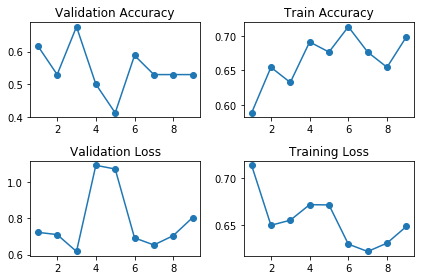

In [31]:
acc=history_new_cnlst.history["acc"]
val_acc=history_new_cnlst.history["val_acc"]
loss=history_new_cnlst.history["loss"]
val_loss=history_new_cnlst.history["val_loss"]
epochs=np.arange(1,10)

plt.figure()
plt.subplot(2,2,1)
plt.plot(epochs,val_acc,'-o')
plt.title('Validation Accuracy')

plt.subplot(2,2,2)
plt.plot(epochs,acc,'-o')
plt.title('Train Accuracy')

plt.subplot(2,2,3)
plt.plot(epochs,val_loss,'-o')
plt.title('Validation Loss')

plt.subplot(2,2,4)
plt.plot(epochs,loss,'-o')
plt.title('Training Loss')


plt.tight_layout()

Model Testing on Test Dataset:
---
Now i am going to test my model on test dataset, where i have 60 videos, 30 from each class. So, let's see if our basic model beats the baseline accuracy of 50%.

In [10]:
modelu_5=load_model('cnn_lstm_model_new3.h5')
modelu_5.evaluate(test_dataset_new,test_labels)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
60/60 [==============================] - 369s 6s/step


[0.5500303943951924, 0.7333333253860473]

So, it's very surprising that this basic architecture gave us the accuracy of 73% on the test_dataset. Which seems pretty good. Now let's change the above mentioned model a bit, make it more complex by adding layers and see where it leads us.

Model 2: CNN and LSTM (A more complex Architecture with more layers)
---

In [11]:
model_cnlst = models.Sequential()
model_cnlst.add(TimeDistributed(Conv2D(128, (3, 3), strides=(1,1),activation='relu'),input_shape=(10, 250, 250, 1)))
model_cnlst.add(TimeDistributed(Conv2D(64, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(MaxPooling2D(2,2)))
model_cnlst.add(TimeDistributed(Conv2D(64, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(Conv2D(32, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(BatchNormalization()))
model_cnlst.add(TimeDistributed(MaxPooling2D(2,2)))

model_cnlst.add(TimeDistributed(Conv2D(64, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(Conv2D(32, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(MaxPooling2D(2,2)))
model_cnlst.add(TimeDistributed(Conv2D(64, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(Conv2D(32, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(MaxPooling2D(2,2)))
model_cnlst.add(TimeDistributed(BatchNormalization()))
model_cnlst.add(TimeDistributed(Flatten()))
model_cnlst.add(Dropout(0.2))

model_cnlst.add(LSTM(64,return_sequences=False,dropout=0.2)) # used 32 units
model_cnlst.add(Dense(128,activation='relu'))
model_cnlst.add(BatchNormalization())
model_cnlst.add(Dense(64,activation='relu'))
model_cnlst.add(Dense(32,activation='relu'))
model_cnlst.add(Dropout(0.2))
model_cnlst.add(Dense(1, activation='sigmoid'))
model_cnlst.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_15 (TimeDis (None, 10, 248, 248, 128) 1280      
_________________________________________________________________
time_distributed_16 (TimeDis (None, 10, 246, 246, 64)  73792     
_________________________________________________________________
time_distributed_17 (TimeDis (None, 10, 123, 123, 64)  0         
_________________________________________________________________
time_distributed_18 (TimeDis (None, 10, 121, 121, 64)  36928     
_________________________________________________________________
time_distributed_19 (TimeDis (None, 10, 119, 119, 32)  18464     
_________________________________________________________________
time_distributed_20 (TimeDis (None, 10, 119, 119, 32)  128       
_________________________________________________________________
time_distributed_21 (TimeDis (None, 10, 59, 59, 32)    0         
__________

Model Compilation and Defining Keras Callbacks:

In [12]:
callbacks_list_cnlst=[keras.callbacks.EarlyStopping(
monitor='acc',patience=3),
               keras.callbacks.ModelCheckpoint(
               filepath='cnn_lstm_model_new4.h5',
               monitor='val_loss',
               save_best_only=True),
                keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 3)
               ]

from keras import optimizers
optimizer_new=optimizers.RMSprop(lr=0.01)
model_cnlst.compile(optimizer=optimizer_new,loss='binary_crossentropy',metrics=['acc'])

In [13]:
history=model_cnlst.fit(train_dataset_new,train_labels,batch_size=10,epochs=20,
                        validation_data=(validation_dataset_new,validation_labels),
                       callbacks=callbacks_list_cnlst)

Instructions for updating:
Use tf.cast instead.
Train on 136 samples, validate on 34 samples
Epoch 1/20
136/136 [==============================] - 650s 5s/step - loss: 0.9695 - acc: 0.5809 - val_loss: 0.7975 - val_acc: 0.6176
Epoch 2/20
136/136 [==============================] - 546s 4s/step - loss: 0.7925 - acc: 0.5074 - val_loss: 0.6667 - val_acc: 0.6471
Epoch 3/20
136/136 [==============================] - 546s 4s/step - loss: 0.7700 - acc: 0.6103 - val_loss: 0.6987 - val_acc: 0.5294
Epoch 4/20
136/136 [==============================] - 521s 4s/step - loss: 0.7031 - acc: 0.6103 - val_loss: 0.8010 - val_acc: 0.5588
Epoch 5/20
136/136 [==============================] - 527s 4s/step - loss: 0.7204 - acc: 0.6324 - val_loss: 0.7340 - val_acc: 0.4706
Epoch 6/20
136/136 [==============================] - 545s 4s/step - loss: 0.6508 - acc: 0.6103 - val_loss: 0.7433 - val_acc: 0.5000
Epoch 7/20
136/136 [==============================] - 551s 4s/step - loss: 0.6338 - acc: 0.6324 - val_loss: 0

In [14]:
acc=history.history["acc"]
val_acc=history.history["val_acc"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=np.arange(1,18)

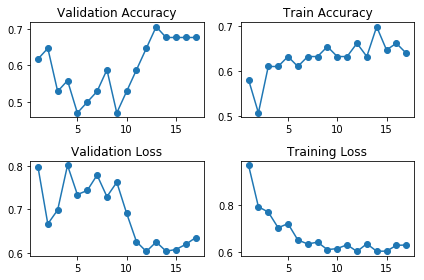

In [16]:
plt.figure()
plt.subplot(2,2,1)
plt.plot(epochs,val_acc,'-o')
plt.title('Validation Accuracy')

plt.subplot(2,2,2)
plt.plot(epochs,acc,'-o')
plt.title('Train Accuracy')

plt.subplot(2,2,3)
plt.plot(epochs,val_loss,'-o')
plt.title('Validation Loss')

plt.subplot(2,2,4)
plt.plot(epochs,loss,'-o')
plt.title('Training Loss')


plt.tight_layout()

The plot above shows that after the 14th epoch there was not any improvement in the validation accuracy, but the good part is that our model didnt overfit this time. the validation accuracy and train accuracy have been nearly the same, and validation accuracy has been better (Maybe a sign of underfitting).
Let's check the test accuracy of the model on our test dataset.

In [17]:
from keras.models import load_model
modelu_5=load_model('cnn_lstm_model_new4.h5')
modelu_5.evaluate(test_dataset_new,test_labels)

60/60 [==============================] - 307s 5s/step


[0.5996537009874979, 0.6499999980131785]

This model architecture gives us about 65% accuracy which is still way better than the baseline 50% accuracy but an intriguing factor is that making our model more complex and deep dropped the test accuracy. Or maybe we might still be underfitting this model as explained above. Maybe i can try adding a few more layers and see where it goes.

3D CNN Architecture:
---
- 3-Dimensional CNN are a type of convolutional neural network that are extensively used in action detection through a moving array of images or videos. 3-D CNN applies the convolution both spatially and temporally at the same time. The previous architecture of TimeDistributed CNN applies convolution operation separately on different frames of a video, such that the weights are learned separately but in a temporal fashion, while in 3-D CNN, the weights are learned in a combined way as the convolution is applied on all the frames together.
- 3-D CNN are computationally very expensive on top of that they are complex aswell, so alot of room to overfit untill we have lots of data. Thus, i would start of with some basic 3-D CNN and see how it works.
- As you can see in the model architecture below, i just defined two convolutional layers in the model and it has about 7 million parameters to learn.
- The model i am going to define is a sequential model and i can use the Keras's Sequential() to define it as i did previously. But i just wanted to try and show the functional API of Keras and how models are defined through the Functional API.

In [26]:
from keras.layers import Conv3D, MaxPooling3D, BatchNormalization, Dropout, Dense, Flatten, concatenate
from keras.models import Model
from keras import Input
# 3D Convolutional Model:
input_model=Input(shape=(10,250,250,1))
layer=Conv3D(32,(3,3,3),strides=(1,1,1),activation='relu')(input_model)
layer=MaxPooling3D((2,2,2))(layer)
layer=Conv3D(64,(3,3,3),strides=(1,1,1),activation='relu')(layer)
layer=MaxPooling3D((2,2,2))(layer)
layer=BatchNormalization()(layer)
layer=Flatten()(layer)
layer=Dense(128,activation='relu')(layer)
layer=Dropout(0.1)(layer)
layer=Dense(64,activation='relu')(layer)
layer=Dense(32,activation='relu')(layer)
layer_output=Dense(1,activation='sigmoid')(layer)

model_3dConv=Model(input_model,layer_output)

model_3dConv.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10, 250, 250, 1)   0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 248, 248, 32)   896       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 4, 124, 124, 32)   0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 2, 122, 122, 64)   55360     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 1, 61, 61, 64)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 61, 61, 64)     256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 238144)            0         
__________

Model Compilation and Fitting:
---

In [40]:
# Conv3d model training:
from keras import optimizers
optimizer_new=optimizers.RMSprop(lr=0.1)
optimizer_adagrad=keras.optimizers.Adagrad(lr=0.01)
callbacks_list_conv_3d=[keras.callbacks.EarlyStopping(
monitor='acc',patience=6),
               keras.callbacks.ModelCheckpoint(
               filepath='stretch_model_conv_3d_new4.h5',
               monitor='val_loss',
               save_best_only=True),
                        keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 2)
               ]
model_3dConv.compile(optimizer=optimizer_adagrad,loss='binary_crossentropy',metrics=['acc'])
conv_3d_model_history=model_3dConv.fit(train_dataset_new,train_labels,batch_size=10,epochs=15,
               validation_data=(validation_dataset_new,validation_labels),
               callbacks=callbacks_list_conv_3d)

Train on 136 samples, validate on 34 samples
Epoch 1/15
136/136 [==============================] - 132s 967ms/step - loss: 6.9611 - acc: 0.5441 - val_loss: 6.6059 - val_acc: 0.5882
Epoch 2/15
136/136 [==============================] - 134s 986ms/step - loss: 7.1946 - acc: 0.5515 - val_loss: 6.6110 - val_acc: 0.5882
Epoch 3/15
136/136 [==============================] - 145s 1s/step - loss: 6.6643 - acc: 0.5809 - val_loss: 7.0696 - val_acc: 0.5588
Epoch 4/15
136/136 [==============================] - 142s 1s/step - loss: 6.1305 - acc: 0.6176 - val_loss: 6.1318 - val_acc: 0.6176
Epoch 5/15
136/136 [==============================] - 141s 1s/step - loss: 6.3637 - acc: 0.6029 - val_loss: 6.1318 - val_acc: 0.6176
Epoch 6/15
136/136 [==============================] - 135s 992ms/step - loss: 5.9090 - acc: 0.6250 - val_loss: 6.1318 - val_acc: 0.6176
Epoch 7/15
136/136 [==============================] - 136s 1s/step - loss: 6.3649 - acc: 0.6029 - val_loss: 6.1318 - val_acc: 0.6176
Epoch 8/15
136/

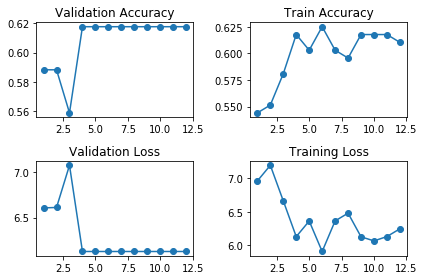

In [42]:
acc=conv_3d_model_history.history["acc"]
val_acc=conv_3d_model_history.history["val_acc"]
loss=conv_3d_model_history.history["loss"]
val_loss=conv_3d_model_history.history["val_loss"]


epochs=np.arange(1,13)

plt.figure()
plt.subplot(2,2,1)
plt.plot(epochs,val_acc,'-o')
plt.title('Validation Accuracy')

plt.subplot(2,2,2)
plt.plot(epochs,acc,'-o')
plt.title('Train Accuracy')

plt.subplot(2,2,3)
plt.plot(epochs,val_loss,'-o')
plt.title('Validation Loss')

plt.subplot(2,2,4)
plt.plot(epochs,loss,'-o')
plt.title('Training Loss')


plt.tight_layout()

Plot shows no signs of overfitting, but it seems like model has hit a bottleneck at around 61% validation accuracy.
Maybe we can try changing the layer configurations and see if it works better or worse. Let's see how it performs on the test_set.

In [43]:
# modelu_6=load_model('stretch_model_conv_3d_new3.h5')
modelu_6=load_model('stretch_model_conv_3d_new4.h5')

modelu_6.evaluate(test_dataset_new,test_labels)

60/60 [==============================] - 38s 626ms/step


[5.597405687967936, 0.65]

Model gave about 65% of test accuracy, which is way less than what we got from the CNN+LSTM Architecture. So, maybe for our task of Recognition of Stretching body, maybe CNN+LSTM architecture is better at identifying and classifying the stretching body.

In [44]:
test_preds=modelu_6.predict(test_dataset_new)

Model Ensembling:
---
- Model Ensembling is a powerful technique where we try to merge the prediction of two or more models that are different in their working and would be as diverse as possible.
- There are many ways through which we can do the ensemble, one of the easiest and most commonly used way is averaging the predictions of all the models. This technique helps reduce the variance but it gives equal weight to all the models. Which means in a classification problem, a weak classifier would have the same weight as the strong classifier. This can undermine the performance sometimes when we have models of diverse nature.
- Thus, i am going to implement a weighed average ensemble (which would give higher weight to the classifier which is strong (Precisely more accurate)) and see which of them performs better in this case.

Weighed Average Ensemble:
---

In [39]:
modelu_cnlst_1=load_model('cnn_lstm_model_new3.h5')
modelu_cnlst_2=load_model('cnn_lstm_model_new4.h5')

model_1_in=modelu_cnlst_1.predict(train_dataset_new)
model_2_in=modelu_cnlst_2.predict(train_dataset_new)
model_3_in=modelu_6.predict(train_dataset_new)

In [40]:
input_dat_in=np.hstack([model_1_in,model_2_in,model_3_in])

In [59]:
from keras import layers
model_ens=models.Sequential()
model_ens.add(layers.Dense(1,activation='linear',input_shape=(3,)))
model_ens.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 1)                 4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [60]:
model_ens.compile(loss='mse',metrics=['acc'],optimizer='rmsprop')

In [61]:
model_ens.fit(input_dat_in,train_labels,batch_size=5,epochs=15,validation_split=0.2)

Train on 108 samples, validate on 28 samples
Epoch 1/15
108/108 [==============================] - 3s 24ms/step - loss: 0.2489 - acc: 0.7870 - val_loss: 0.7253 - val_acc: 0.2143
Epoch 2/15
108/108 [==============================] - 0s 330us/step - loss: 0.2180 - acc: 0.7685 - val_loss: 0.6558 - val_acc: 0.2143
Epoch 3/15
108/108 [==============================] - 0s 370us/step - loss: 0.1979 - acc: 0.7778 - val_loss: 0.6024 - val_acc: 0.3214
Epoch 4/15
108/108 [==============================] - 0s 296us/step - loss: 0.1850 - acc: 0.7870 - val_loss: 0.5583 - val_acc: 0.3929
Epoch 5/15
108/108 [==============================] - 0s 297us/step - loss: 0.1762 - acc: 0.7870 - val_loss: 0.5195 - val_acc: 0.3929
Epoch 6/15
108/108 [==============================] - 0s 381us/step - loss: 0.1707 - acc: 0.7778 - val_loss: 0.4896 - val_acc: 0.3929
Epoch 7/15
108/108 [==============================] - 0s 296us/step - loss: 0.1674 - acc: 0.7778 - val_loss: 0.4676 - val_acc: 0.4286
Epoch 8/15
108/108

In [46]:
model_1_out=modelu_cnlst_1.predict(test_dataset_new)
model_2_out=modelu_cnlst_2.predict(test_dataset_new)
model_3_out=modelu_6.predict(test_dataset_new)

In [47]:
model_out_final=np.hstack([model_1_out,model_2_out,model_3_out])

In [62]:
ensemble_loss,ensemble_accuracy=model_ens.evaluate(model_out_final,test_labels)
ensemble_accuracy

60/60 [==============================] - 0s 120us/step


0.7333333273728688

Real Time Prediction on a Video:
---

To see how the model performs on one video where there is stretching in some part of it and then there is no stretching in the other parts, i have created some functions that would help us do the real time predictions on those long videos.

Functions:
---
- Below i created a function named a s "video_folder_create", it requires three arguments:
"path" = Your current working directory, in my case its desktop.
"video_folder_name" = Name of the folder in which we would put the short 5 seconds clips from each video to be tested.
"video_name" = Name of the video file, and i have assumed that video file is in the working directory in which you are working, as in my case the video file is on my desktop.
- I have 5 videos each of the duration 50 seconds, and i would be performing real time predictions on all these videos using the best 2 models i have trained previously.
- Then i have defined a "real_time_prediction" function that takes "path" and "video_folder_name" as two arguments. This function then reads the frames from each of the subclip of the complete video, do the prediction using the two best trained models i defined earlier, and generate one prediction by averaging the predictions from both of them.
- After this i have a plotting mechanism for each video where x-axis is the time axis where prediction is made for 5s intervals of a complete video and y-axis is the prediction axis.

Loading the two best models:
---

In [6]:
modelu_cnlst_1=load_model('cnn_lstm_model_new3.h5')
modelu_cnlst_2=load_model('cnn_lstm_model_new4.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [16]:
path='C:\\Users\\Muhammad Hussain\\Desktop'

Video Folder Create Function:
---

In [20]:
from moviepy.video.io.VideoFileClip import VideoFileClip
def video_folder_create(path,video_folder_name,video_name):
    video_folder_path=os.path.join(path,video_folder_name)
    try:
        os.mkdir(os.path.join(path,video_folder_name))
    except:
        print("Folder already created")
    input_video_path=os.path.join(path,video_name)
    times=[[0,5],[6,10],[11,15],[16,20],[21,25],[26,30],[31,35],[36,40],[41,45],[46,50]]
    for i in np.arange(len(times)):
        vid_name="vid_%d.mp4" % i
        output_video_path=os.path.join(video_folder_path,vid_name)
        with VideoFileClip(input_video_path) as video:
            new = video.subclip(times[i][0], times[i][1])
            new.write_videofile(output_video_path,audio_codec='aac')
    return True

# Creating 5 folders for 5 test videos:
video_folder_create(path,'test_rl_1','test_rl_1.mp4')
video_folder_create(path,'test_rl_2','test_rl_2.mp4')
video_folder_create(path,'test_rl_3','test_rl_3.mp4')
video_folder_create(path,'test_rl_4','test_rl_4.mp4')
video_folder_create(path,'test_rl_5','test_rl_5.mp4')




Folder already created
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_1\vid_0.mp4.
MoviePy - Writing audio in vid_0TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_1\vid_0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_1\vid_0.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_1\vid_1.mp4.
MoviePy - Writing audio in vid_1TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_1\vid_1.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_1\vid_1.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_1\vid_2.mp4.
MoviePy - Writing audio in vid_2TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_1\vid_2.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_1\vid_2.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_1\vid_3.mp4.
MoviePy - Writing audio in vid_3TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_1\vid_3.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_1\vid_3.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_1\vid_4.mp4.
MoviePy - Writing audio in vid_4TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_1\vid_4.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_1\vid_4.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_1\vid_5.mp4.
MoviePy - Writing audio in vid_5TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_1\vid_5.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_1\vid_5.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_1\vid_6.mp4.
MoviePy - Writing audio in vid_6TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_1\vid_6.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_1\vid_6.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_1\vid_7.mp4.
MoviePy - Writing audio in vid_7TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_1\vid_7.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_1\vid_7.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_1\vid_8.mp4.
MoviePy - Writing audio in vid_8TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_1\vid_8.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_1\vid_8.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_1\vid_9.mp4.
MoviePy - Writing audio in vid_9TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_1\vid_9.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_1\vid_9.mp4
Folder already created
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_2\vid_0.mp4.
MoviePy - Writing audio in vid_0TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_2\vid_0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_2\vid_0.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_2\vid_1.mp4.
MoviePy - Writing audio in vid_1TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_2\vid_1.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_2\vid_1.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_2\vid_2.mp4.
MoviePy - Writing audio in vid_2TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_2\vid_2.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_2\vid_2.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_2\vid_3.mp4.
MoviePy - Writing audio in vid_3TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_2\vid_3.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_2\vid_3.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_2\vid_4.mp4.
MoviePy - Writing audio in vid_4TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_2\vid_4.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_2\vid_4.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_2\vid_5.mp4.
MoviePy - Writing audio in vid_5TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_2\vid_5.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_2\vid_5.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_2\vid_6.mp4.
MoviePy - Writing audio in vid_6TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_2\vid_6.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_2\vid_6.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_2\vid_7.mp4.
MoviePy - Writing audio in vid_7TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_2\vid_7.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_2\vid_7.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_2\vid_8.mp4.
MoviePy - Writing audio in vid_8TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_2\vid_8.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_2\vid_8.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_2\vid_9.mp4.
MoviePy - Writing audio in vid_9TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_2\vid_9.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_2\vid_9.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_3\vid_0.mp4.
MoviePy - Writing audio in vid_0TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_3\vid_0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_3\vid_0.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_3\vid_1.mp4.
MoviePy - Writing audio in vid_1TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_3\vid_1.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_3\vid_1.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_3\vid_2.mp4.
MoviePy - Writing audio in vid_2TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_3\vid_2.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_3\vid_2.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_3\vid_3.mp4.
MoviePy - Writing audio in vid_3TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_3\vid_3.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_3\vid_3.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_3\vid_4.mp4.
MoviePy - Writing audio in vid_4TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_3\vid_4.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_3\vid_4.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_3\vid_5.mp4.
MoviePy - Writing audio in vid_5TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_3\vid_5.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_3\vid_5.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_3\vid_6.mp4.
MoviePy - Writing audio in vid_6TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_3\vid_6.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_3\vid_6.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_3\vid_7.mp4.
MoviePy - Writing audio in vid_7TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_3\vid_7.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_3\vid_7.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_3\vid_8.mp4.
MoviePy - Writing audio in vid_8TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_3\vid_8.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_3\vid_8.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_3\vid_9.mp4.
MoviePy - Writing audio in vid_9TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_3\vid_9.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_3\vid_9.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_4\vid_0.mp4.
MoviePy - Writing audio in vid_0TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_4\vid_0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_4\vid_0.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_4\vid_1.mp4.
MoviePy - Writing audio in vid_1TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_4\vid_1.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_4\vid_1.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_4\vid_2.mp4.
MoviePy - Writing audio in vid_2TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_4\vid_2.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_4\vid_2.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_4\vid_3.mp4.
MoviePy - Writing audio in vid_3TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_4\vid_3.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_4\vid_3.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_4\vid_4.mp4.
MoviePy - Writing audio in vid_4TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_4\vid_4.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_4\vid_4.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_4\vid_5.mp4.
MoviePy - Writing audio in vid_5TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_4\vid_5.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_4\vid_5.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_4\vid_6.mp4.
MoviePy - Writing audio in vid_6TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_4\vid_6.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_4\vid_6.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_4\vid_7.mp4.
MoviePy - Writing audio in vid_7TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_4\vid_7.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_4\vid_7.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_4\vid_8.mp4.
MoviePy - Writing audio in vid_8TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_4\vid_8.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_4\vid_8.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_4\vid_9.mp4.
MoviePy - Writing audio in vid_9TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_4\vid_9.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_4\vid_9.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_5\vid_0.mp4.
MoviePy - Writing audio in vid_0TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_5\vid_0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_5\vid_0.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_5\vid_1.mp4.
MoviePy - Writing audio in vid_1TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_5\vid_1.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_5\vid_1.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_5\vid_2.mp4.
MoviePy - Writing audio in vid_2TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_5\vid_2.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_5\vid_2.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_5\vid_3.mp4.
MoviePy - Writing audio in vid_3TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_5\vid_3.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_5\vid_3.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_5\vid_4.mp4.
MoviePy - Writing audio in vid_4TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_5\vid_4.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_5\vid_4.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_5\vid_5.mp4.
MoviePy - Writing audio in vid_5TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_5\vid_5.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_5\vid_5.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_5\vid_6.mp4.
MoviePy - Writing audio in vid_6TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_5\vid_6.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_5\vid_6.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_5\vid_7.mp4.
MoviePy - Writing audio in vid_7TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_5\vid_7.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_5\vid_7.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_5\vid_8.mp4.
MoviePy - Writing audio in vid_8TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_5\vid_8.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_5\vid_8.mp4
Moviepy - Building video C:\Users\Muhammad Hussain\Desktop\test_rl_5\vid_9.mp4.
MoviePy - Writing audio in vid_9TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video C:\Users\Muhammad Hussain\Desktop\test_rl_5\vid_9.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Muhammad Hussain\Desktop\test_rl_5\vid_9.mp4


True

Real Time Prediction Function:
---

In [63]:

def real_time_prediction(path,video_folder_name):
    folder_path=os.path.join(path,video_folder_name)
    video_list=os.listdir(folder_path)
    prediction_list_1=[]
    prediction_list_2=[]
    prediction_list_3=[]
    for i in np.arange(len(video_list)):
        video_path=os.path.join(folder_path,video_list[i])
        cap=cv2.VideoCapture(video_path)
        cap.set(cv2.CAP_PROP_FPS, 1)
        frameRate=cap.get(5)
        x=1
        count=0
        frame_saved=[]
        while(cap.isOpened()):
            frameId = cap.get(1) #current frame number
            ret, frame = cap.read()
            if (ret != True):
                break
            if (frameId % math.floor(frameRate) == 0):
                frame_grey=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                frame_grey=cv2.resize(frame_grey,(250,250))
                frame_grey=frame_grey/255
                frame_saved.append(frame_grey)
        cap.release()
        frame_diff=10-len(frame_saved)
        if frame_diff>0:
            for k in np.arange(frame_diff):
                frame_saved.append(frame_saved[k])
        else:
            pass
        frame_saved=frame_saved[:10]
        frame_saved=np.array(frame_saved)
        dats=frame_saved.reshape((1,10,250,250,1))
        prediction_list_1.append(modelu_cnlst_1.predict(dats))
        prediction_list_2.append(modelu_cnlst_2.predict(dats))
        prediction_list_3.append(modelu_6.predict(dats))
    return prediction_list_1,prediction_list_2

1st Video Predictions:
---

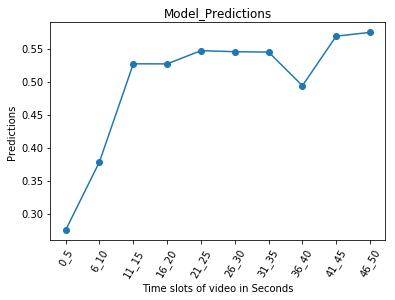

In [64]:
# video_folder_create(path,'test_rl_1','test_rl_1.mp4')
prediction_model_1,prediction_model_2=real_time_prediction(path,"test_rl_1")
predu_1=[]
for i in prediction_model_1:
    predu_1.append(list(i[0])[0])
predu_2=[]
for i in prediction_model_2:
    predu_2.append(list(i[0])[0])
predu_3=[]
for i in prediction_model_3:
    predu_3.append(list(i[0])[0])
times=[[0,5],[6,10],[11,15],[16,20],[21,25],[26,30],[31,35],[36,40],[41,45],[46,50]]
time_axis=[]
for i in times:
    time_axis.append(str(i[0])+"_"+str(i[1]))
    
main_preds=0.6*(np.array(predu_1))+0.4*(np.array(predu_2))


    
plt.figure()
plt.plot(time_axis,main_preds,"-o")
plt.xlabel("Time slots of video in Seconds")
plt.xticks(rotation=60)
plt.ylabel("Predictions")
plt.title("Model_Predictions")
plt.show()

2nd Video Predictions:
---

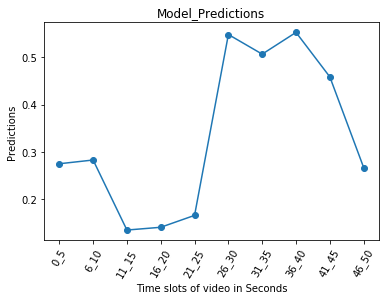

In [65]:
prediction_model_1,prediction_model_2=real_time_prediction(path,"test_rl_2")
predu_1=[]
for i in prediction_model_1:
    predu_1.append(list(i[0])[0])
predu_2=[]
for i in prediction_model_2:
    predu_2.append(list(i[0])[0])
times=[[0,5],[6,10],[11,15],[16,20],[21,25],[26,30],[31,35],[36,40],[41,45],[46,50]]
time_axis=[]
for i in times:
    time_axis.append(str(i[0])+"_"+str(i[1]))
    
# main_preds=np.average(np.array([predu_1,predu_2]),axis=0)
main_preds=0.6*(np.array(predu_1))+0.4*(np.array(predu_2))

    
plt.figure()
plt.plot(time_axis,main_preds,"-o")
plt.xlabel("Time slots of video in Seconds")
plt.xticks(rotation=60)
plt.ylabel("Predictions")
plt.title("Model_Predictions")
plt.show()

3rd Video Predictions:
---

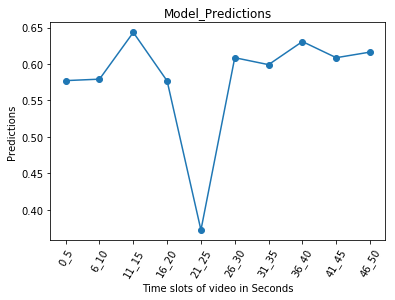

In [66]:
prediction_model_1,prediction_model_2=real_time_prediction(path,"test_rl_3")
predu_1=[]
for i in prediction_model_1:
    predu_1.append(list(i[0])[0])
predu_2=[]
for i in prediction_model_2:
    predu_2.append(list(i[0])[0])
times=[[0,5],[6,10],[11,15],[16,20],[21,25],[26,30],[31,35],[36,40],[41,45],[46,50]]
time_axis=[]
for i in times:
    time_axis.append(str(i[0])+"_"+str(i[1]))
    
# main_preds=np.average(np.array([predu_1,predu_2]),axis=0)
main_preds=0.6*(np.array(predu_1))+0.4*(np.array(predu_2))

    
plt.figure()
plt.plot(time_axis,main_preds,"-o")
plt.xlabel("Time slots of video in Seconds")
plt.xticks(rotation=60)
plt.ylabel("Predictions")
plt.title("Model_Predictions")
plt.show()

4th Video Predictions:
---

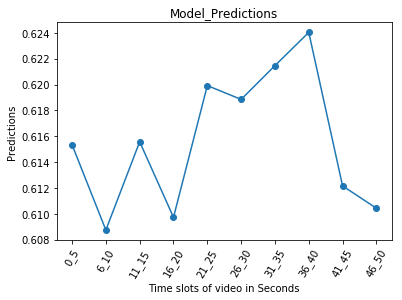

In [68]:
prediction_model_1,prediction_model_2=real_time_prediction(path,"test_rl_4")
predu_1=[]
for i in prediction_model_1:
    predu_1.append(list(i[0])[0])
predu_2=[]
for i in prediction_model_2:
    predu_2.append(list(i[0])[0])
times=[[0,5],[6,10],[11,15],[16,20],[21,25],[26,30],[31,35],[36,40],[41,45],[46,50]]
time_axis=[]
for i in times:
    time_axis.append(str(i[0])+"_"+str(i[1]))
    
# main_preds=np.average(np.array([predu_1,predu_2]),axis=0)
main_preds=0.6*(np.array(predu_1))+0.4*(np.array(predu_2))

    
plt.figure()
plt.plot(time_axis,main_preds,"-o")
plt.xlabel("Time slots of video in Seconds")
plt.xticks(rotation=60)
plt.ylabel("Predictions")
plt.title("Model_Predictions")
plt.show()

5th Video Predictions:
---

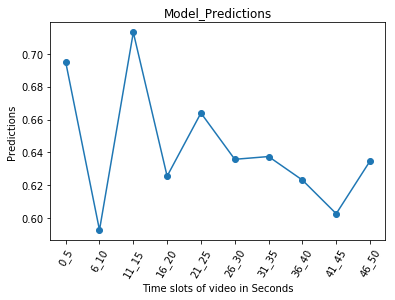

In [74]:
prediction_model_1,prediction_model_2=real_time_prediction(path,"test_rl_5")
predu_1=[]
for i in prediction_model_1:
    predu_1.append(list(i[0])[0])
predu_2=[]
for i in prediction_model_2:
    predu_2.append(list(i[0])[0])
times=[[0,5],[6,10],[11,15],[16,20],[21,25],[26,30],[31,35],[36,40],[41,45],[46,50]]
time_axis=[]
for i in times:
    time_axis.append(str(i[0])+"_"+str(i[1]))
    
# main_preds=np.average(np.array([predu_1,predu_2]),axis=0)
main_preds=0.6*(np.array(predu_1))+0.4*(np.array(predu_2))

    
plt.figure()
plt.plot(time_axis,main_preds,"-o")
plt.xlabel("Time slots of video in Seconds")
plt.xticks(rotation=60)
plt.ylabel("Predictions")
plt.title("Model_Predictions")
plt.show()